

From: Shilpi

In [58]:
import warnings
warnings.filterwarnings('ignore')

from sigpyproc.readers import FilReader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import dates
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
from datetime import datetime, timedelta
import astropy.units as u
from astropy.time import Time
from astropy.visualization import ImageNormalize, PercentileInterval

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

# print(plt.get_backend())
path = '/home/mnedal/data/ilofar'

In [138]:
stokes = 'V'
filename = f'{path}/Sun357_20240514_stokes{stokes}.fil'

In [139]:
a = FilReader(filename) # header
header = a.header.to_dict()

In [140]:
header

{'filename': '/home/mnedal/data/ilofar/Sun357_20240514_stokesV.fil',
 'data_type': 'filterbank',
 'nchans': 488,
 'foff': -0.1953125,
 'fch1': 200.0,
 'nbits': 32,
 'tsamp': 0.00131072,
 'tstart': 60444.418055551,
 'nsamples': 24902343,
 'nifs': 1,
 'coord': <SkyCoord (ICRS): (ra, dec) in deg
     (0., 0.)>,
 'azimuth': <Angle 297.27495739 deg>,
 'zenith': <Angle 52.16498088 deg>,
 'telescope': 'MeerKAT',
 'backend': 'FAKE',
 'source': 'Sun357',
 'frame': 'topocentric',
 'ibeam': 0,
 'nbeams': 0,
 'dm': 0,
 'period': 0,
 'accel': 0,
 'signed': False,
 'rawdatafile': 'unknown',
 'stream_info': {'entries': [{'filename': '/home/mnedal/data/ilofar/Sun357_20240514_stokesV.fil',
    'hdrlen': 347,
    'datalen': 48609373536,
    'nsamples': 24902343,
    'tstart': 60444.418055551,
    'tsamp': 0.00131072}]},
 'basename': 'Sun357_20240514_stokesV',
 'extension': '.fil',
 'telescope_id': 64,
 'machine_id': 0,
 'bandwidth': 95.3125,
 'ftop': 200.09765625,
 'fbottom': 104.78515625,
 'fcenter': 1

In [141]:
tstart_obs_str = Time(a.header.tstart, format='mjd').iso
tstart = datetime.strptime(tstart_obs_str, '%Y-%m-%d %H:%M:%S.%f')

tstart_str = '2024-05-14 16:35:00'
tend_str   = '2024-05-14 17:50:00'
datetime1 = datetime.strptime(tstart_str, '%Y-%m-%d %H:%M:%S')
datetime2 = datetime.strptime(tend_str, '%Y-%m-%d %H:%M:%S')

print(tstart, datetime1, datetime2, sep='\n')

time_difference1 = datetime1 - tstart
time_difference2 = datetime2 - datetime1

secondsFromStart = time_difference1.total_seconds()
totalTime = time_difference2.total_seconds()

print(secondsFromStart, totalTime, sep='\n')

2024-05-14 10:02:00
2024-05-14 16:35:00
2024-05-14 17:50:00
23580.0
4500.0


In [142]:
# downsampling the data to time resolution of 0.5 s. the time resolution to 0.5 s > 500 ms. And 500/1.31 ms = ~381. So tfactor should be 381.
data = a.read_block(int(secondsFromStart / a.header.tsamp), int(totalTime / a.header.tsamp))
# np.save(f'{path}/realta_ilofar.npy', data)

In [143]:
# data.nbytes/(1024*1024*1024) # data size in GB

In [144]:
print(data.shape, data.shape[1]*a.header.tsamp, sep='\n')

(488, 3433227)
4499.99929344


In [145]:
# define time cadense in ms.
Tres = 10                  # time resolution of n millisecond
tres = a.header.tsamp*1e3  # time resolution in header

# downsampling data applied by summing sequential sample/channels and averaging the data
data2 = data.downsample(tfactor=int(Tres/tres))
data2.shape

(488, 490461)

In [146]:
np.save(f'{path}/res_{Tres}ms_ilofar_stokes{stokes}.npy', data2)

In [147]:
# Creating time axis
tstart = Time(data2.header.tstart, format='mjd')                 # tstart.iso will tell the time in format yyyy-mm-dd hh:mm:ss
# tarray = tstart + (np.arange(data2.shape[1])*(Tres/1000)*u.s)  # Creating the time array for Tres time res.
tarray = tstart + (np.arange(data2.shape[1])*data2.header.tsamp*u.s) # Creating the time array for realta time resolution
tarray[-1].iso

'2024-05-14 17:49:59.989'

In [148]:
dt = datetime.strptime(tarray[1].iso, '%Y-%m-%d %H:%M:%S.%f') - datetime.strptime(tarray[0].iso, '%Y-%m-%d %H:%M:%S.%f')
dt.total_seconds()*1000 # in ms.

9.0

In [149]:
Tarray = [datetime.strptime(t.iso, '%Y-%m-%d %H:%M:%S.%f') for t in tarray] # Converting the array to datetime object
Tarray = np.array(Tarray)
np.save(f'{path}/time_{Tres}ms_stokes{stokes}.npy', Tarray)

In [150]:
print(Tarray[0], Tarray[1], Tarray[-1], sep='\n')

2024-05-14 16:34:59.999000
2024-05-14 16:35:00.008000
2024-05-14 17:49:59.989000


In [151]:
print(Tarray[1]-Tarray[0], Tarray[-1]-Tarray[-2], sep='\n')

0:00:00.009000
0:00:00.009000


In [152]:
# export the frequency axis
freqs = data2.header.chan_freqs
np.save(f'{path}/freq_{Tres}ms_stokes{stokes}.npy', freqs)

---

### Import the exported data files

In [153]:
# import the data files
Tres = 10 # in ms.
stokes = 'V'
data = np.load(f'{path}/res_{Tres}ms_ilofar_stokes{stokes}.npy')
time = np.load(f'{path}/time_{Tres}ms_stokes{stokes}.npy', allow_pickle=True)
freqs = np.load(f'{path}/freq_{Tres}ms_stokes{stokes}.npy')

In [154]:
(time[1] - time[0]).total_seconds()

0.009

In [155]:
def freq_axis(freqs):
    '''
    Introduce gaps in the frequency axis of I-LOFAR REALTA data.
    '''
    gap1 = np.flipud(freqs[288]+(np.arange(59)*0.390625))
    gap2 = np.flipud(freqs[88]+(np.arange(57)*0.390625))
    ax_shape = 59+57-1
    new_freq = np.zeros(ax_shape+freqs.shape[0])
    
    new_freq[0:88] = freqs[0:88]
    new_freq[88:145]  = gap2[:57]
    new_freq[145:345] = freqs[88:288]
    new_freq[345:404] = gap1[:59]
    new_freq[404:] = freqs[289:]
    
    return new_freq

In [156]:
new_freq = freq_axis(freqs)

data = np.log10(data)
data[np.where(np.isinf(data)==True)] = 0.0

data2 = np.empty((new_freq.shape[0], data.shape[1]))    
data2[:] = np.NaN
data2[0:88] = data[0:88]
data2[145:345] = data[88:288]
data2[404:] = data[289:]

# times_mpl = [mdates.date2num(t) for t in time]

In [157]:
freq_mode3 = np.linspace(10, 90, 199)
freq_mode5 = np.linspace(110, 190, 200)
freq_mode7 = np.linspace(210, 270, 88)

# downsample the data
df_mode3 = pd.DataFrame(data=data2[404:].T, columns=freq_mode3[::-1])
df_mode5 = pd.DataFrame(data=data2[145:345].T, columns=freq_mode5[::-1])
df_mode7 = pd.DataFrame(data=data2[:88].T, columns=freq_mode7[::-1])

In [158]:
print(df_mode3.shape, df_mode5.shape, df_mode7.shape, sep='\n')

(490461, 199)
(490461, 200)
(490461, 88)


In [159]:
# Save the dataframes as a pickle files
df_mode3.to_pickle(f'{path}/df_mode3_{Tres}ms_stokes{stokes}.pkl')
df_mode5.to_pickle(f'{path}/df_mode5_{Tres}ms_stokes{stokes}.pkl')
df_mode7.to_pickle(f'{path}/df_mode7_{Tres}ms_stokes{stokes}.pkl')

---

In [265]:
# Load the dataframes from the pickle files
Tres = 10
stokes = 'V'

df_mode3 = pd.read_pickle(f'{path}/df_mode3_{Tres}ms_stokes{stokes}.pkl')
df_mode5 = pd.read_pickle(f'{path}/df_mode5_{Tres}ms_stokes{stokes}.pkl')
df_mode7 = pd.read_pickle(f'{path}/df_mode7_{Tres}ms_stokes{stokes}.pkl')
time = np.load(f'{path}/time_{Tres}ms_stokes{stokes}.npy', allow_pickle=True)
# freqs = np.load(f'{path}/freq_{Tres}ms_stokes{stokes}.npy')

In [266]:
# Ensure the 'time' column is in datetime format
df_mode3.index = pd.to_datetime(time)
df_mode5.index = pd.to_datetime(time)
df_mode7.index = pd.to_datetime(time)

In [267]:
print(df_mode3.shape, df_mode5.shape, df_mode7.shape, sep='\n')

(490461, 199)
(490461, 200)
(490461, 88)


In [268]:
display(df_mode3.head(3)), display(df_mode3.tail(3))

90.000000  89.595960  89.191919  88.787879  \
2024-05-14 16:34:59.999   0.135079   0.492763   0.089122  -0.258385   
2024-05-14 16:35:00.008   0.159427  -0.063079        NaN  -0.364908   
2024-05-14 16:35:00.018   0.073875   0.094413   0.186178   0.014034   

                         88.383838  87.979798  87.575758  87.171717  \
2024-05-14 16:34:59.999  -0.044289  -0.250823   0.031603        NaN   
2024-05-14 16:35:00.008   0.077761  -0.607288  -0.918808  -0.051569   
2024-05-14 16:35:00.018        NaN  -0.450582   0.140908  -0.250327   

                         86.767677  86.363636  ...  13.636364  13.232323  \
2024-05-14 16:34:59.999        NaN   0.328438  ...   0.895011   4.267043   
2024-05-14 16:35:00.008  -0.416340   0.371640  ...   3.437584   2.770582   
2024-05-14 16:35:00.018   0.234712   0.196129  ...   3.603714   4.057149   

                         12.828283  12.424242  12.020202  11.616162  \
2024-05-14 16:34:59.999   2.298013   3.340421        NaN   1.754052   
2024-05-14 16:35:00.008   2.236599   3.292307        NaN   2.281595   
2024-05-14 16:35:00.018   2.118789   3.363568        NaN   0.767399   

                         11.212121  10.808081  10.404040  10.000000  
2024-05-14 16:34:59.999        NaN   1.058668   5.134039   3.813875  
2024-05-14 16:35:00.008        NaN   0.805750   5.105818   3.731729  
2024-05-14 16:35:00.018        NaN   1.493830   5.052745   3.717402  

[3 rows x 199 columns]

90.000000  89.595960  89.191919  88.787879  \
2024-05-14 17:49:59.971   0.781503   0.643674   0.777902   0.904400   
2024-05-14 17:49:59.980   0.917830   0.761420   0.671692   0.787329   
2024-05-14 17:49:59.989   0.817619   0.823156   0.868407   0.753501   

                         88.383838  87.979798  87.575758  87.171717  \
2024-05-14 17:49:59.971   0.717992   0.713534   0.684567   0.945128   
2024-05-14 17:49:59.980   0.687941   0.640189   0.761951   0.678565   
2024-05-14 17:49:59.989   0.539768   0.643470   0.820224   0.806884   

                         86.767677  86.363636  ...  13.636364  13.232323  \
2024-05-14 17:49:59.971   0.442454   0.402938  ...   3.782071   4.257983   
2024-05-14 17:49:59.980   0.888239   0.962643  ...   3.810467   4.014115   
2024-05-14 17:49:59.989   0.730455   0.698873  ...   3.873961   3.877604   

                         12.828283  12.424242  12.020202  11.616162  \
2024-05-14 17:49:59.971   4.576818   4.041413   2.689538   4.200524   
2024-05-14 17:49:59.980   4.366066   5.011581   2.811875   4.311533   
2024-05-14 17:49:59.989   4.097024   5.282350   2.872154   4.325539   

                         11.212121  10.808081  10.404040  10.000000  
2024-05-14 17:49:59.971   4.710043        NaN   3.835423        NaN  
2024-05-14 17:49:59.980   4.736470        NaN   4.400236        NaN  
2024-05-14 17:49:59.989   4.838773        NaN   3.583567        NaN  

[3 rows x 199 columns]

(None, None)

---

In [269]:
df_mode3 = df_mode3.resample('1S').mean()
df_mode5 = df_mode5.resample('1S').mean()
df_mode7 = df_mode7.resample('1S').mean()

In [270]:
fig_title = str(time[0].date()).replace("-","") + f'_Tres_{Tres}ms_stokes{stokes}'

In [ ]:
del time
del freqs
del data
del data2
del new_freq

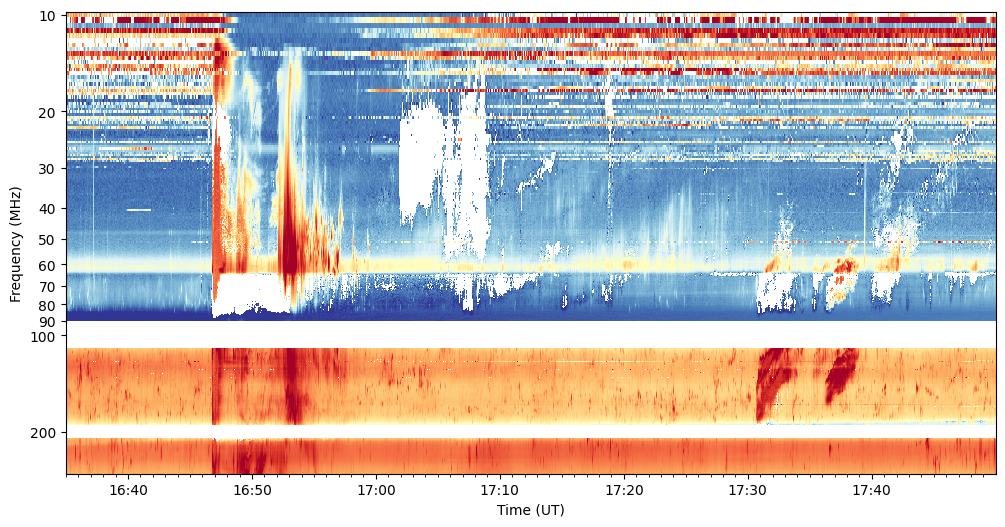

In [175]:
if stokes == 'I':
    min_range_mode3 = np.nanpercentile(df_mode3.values, 10)
    max_range_mode3 = np.nanpercentile(df_mode3.values, 97)
    
    min_range_mode5 = np.nanpercentile(df_mode5.values, 10)
    max_range_mode5 = np.nanpercentile(df_mode5.values, 97)
    
    min_range_mode7 = np.nanpercentile(df_mode7.values, 10)
    max_range_mode7 = np.nanpercentile(df_mode7.values, 97)

elif stokes == 'V':
    min_range_mode3 = 0.1
    min_range_mode5 = 0.1
    min_range_mode7 = 0.1
    
    max_range_mode3 = 5
    max_range_mode5 = 5
    max_range_mode7 = 5

fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(111)
ax.pcolormesh(df_mode3.index, df_mode3.columns, df_mode3.values.T,
                    vmin=min_range_mode3, vmax=max_range_mode3,
                    cmap='RdYlBu_r')
ax.pcolormesh(df_mode5.index, df_mode5.columns, df_mode5.values.T,
                    vmin=min_range_mode5, vmax=max_range_mode5,
                    cmap='RdYlBu_r')
ax.pcolormesh(df_mode7.index, df_mode7.columns, df_mode7.values.T,
                    vmin=min_range_mode7, vmax=max_range_mode7,
                    cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.xaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(ax.get_ylim()[::-1])
# fig.savefig(f'{path}/plots/realta_ilofar_{fig_title}.png', format='png', bbox_inches='tight')
# fig.savefig(f'{path}/plots/realta_ilofar_{fig_title}.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [272]:
# remove the const background
mode3_new = df_mode3.values - np.tile(np.nanmean(df_mode3.values,0), (df_mode3.values.shape[0],1))
mode5_new = df_mode5.values - np.tile(np.nanmean(df_mode5.values,0), (df_mode5.values.shape[0],1))
mode7_new = df_mode7.values - np.tile(np.nanmean(df_mode7.values,0), (df_mode7.values.shape[0],1))

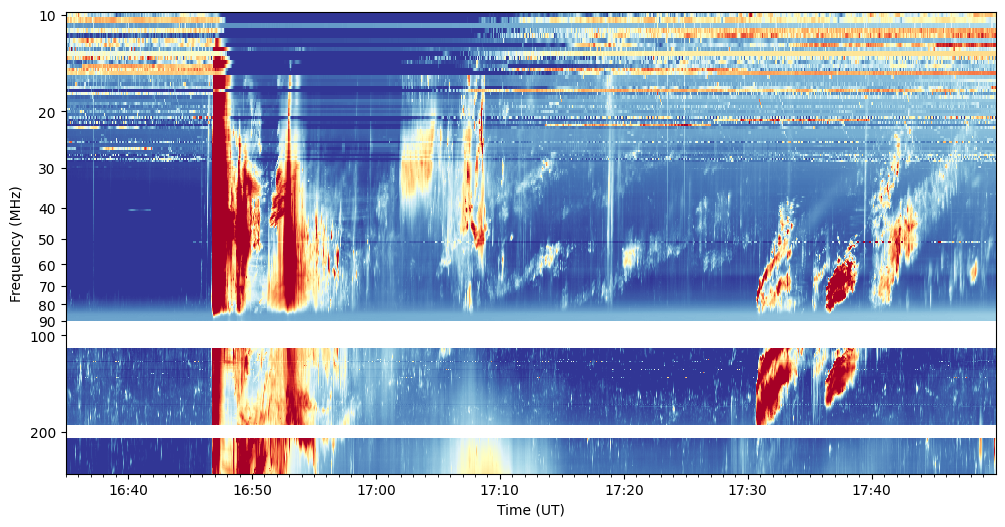

In [117]:
min_range = -0.5
max_range = 2

fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(111)
ax.pcolormesh(df_mode3.index, df_mode3.columns, mode3_new.T,
              vmin=min_range, vmax=max_range,
                    cmap='RdYlBu_r')
ax.pcolormesh(df_mode5.index, df_mode5.columns, mode5_new.T,
              vmin=min_range, vmax=max_range,
                    cmap='RdYlBu_r')
ax.pcolormesh(df_mode7.index, df_mode7.columns, mode7_new.T,
              vmin=min_range, vmax=max_range,
                    cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.xaxis.set_minor_locator(AutoMinorLocator(n=10))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(ax.get_ylim()[::-1])
fig.savefig(f'{path}/plots/realta_ilofar_{fig_title}_backgroundSubtracted.png', format='png', bbox_inches='tight')
plt.show()

### Zoom-in certain features

In [296]:
Tres = 10
stokes = 'V'

# Load the dataframes from the pickle files
df_mode3 = pd.read_pickle(f'{path}/df_mode3_{Tres}ms_stokes{stokes}.pkl')
df_mode5 = pd.read_pickle(f'{path}/df_mode5_{Tres}ms_stokes{stokes}.pkl')
df_mode7 = pd.read_pickle(f'{path}/df_mode7_{Tres}ms_stokes{stokes}.pkl')
time = np.load(f'{path}/time_{Tres}ms_stokes{stokes}.npy', allow_pickle=True)

freqs_mode3 = df_mode3.columns
freqs_mode5 = df_mode5.columns
freqs_mode7 = df_mode7.columns

# remove the const background
mode3_new = df_mode3.values - np.tile(np.nanmean(df_mode3.values,0), (df_mode3.values.shape[0],1))
mode5_new = df_mode5.values - np.tile(np.nanmean(df_mode5.values,0), (df_mode5.values.shape[0],1))
mode7_new = df_mode7.values - np.tile(np.nanmean(df_mode7.values,0), (df_mode7.values.shape[0],1))

del df_mode3
del df_mode5
del df_mode7

df_mode3 = pd.DataFrame(data=mode3_new, columns=freqs_mode3)
df_mode5 = pd.DataFrame(data=mode5_new, columns=freqs_mode5)
df_mode7 = pd.DataFrame(data=mode7_new, columns=freqs_mode7)

# Ensure the 'time' column is in datetime format
df_mode3.index = pd.to_datetime(time)
df_mode5.index = pd.to_datetime(time)
df_mode7.index = pd.to_datetime(time)

In [297]:
# downsample the data
df_mode3 = df_mode3.resample('100ms').mean()
df_mode5 = df_mode5.resample('100ms').mean()
df_mode7 = df_mode7.resample('100ms').mean()

In [298]:
df_mode3.shape

(45001, 199)

In [126]:
# Slice the DataFrame between start_date and end_date
start_date = '2024-05-14 16:45:00'
end_date   = '2024-05-14 17:00:00'

df_mode3_slice = df_mode3.loc[start_date:end_date]
df_mode5_slice = df_mode5.loc[start_date:end_date]
df_mode7_slice = df_mode7.loc[start_date:end_date]

In [127]:
df_mode3_slice.shape

(9010, 199)

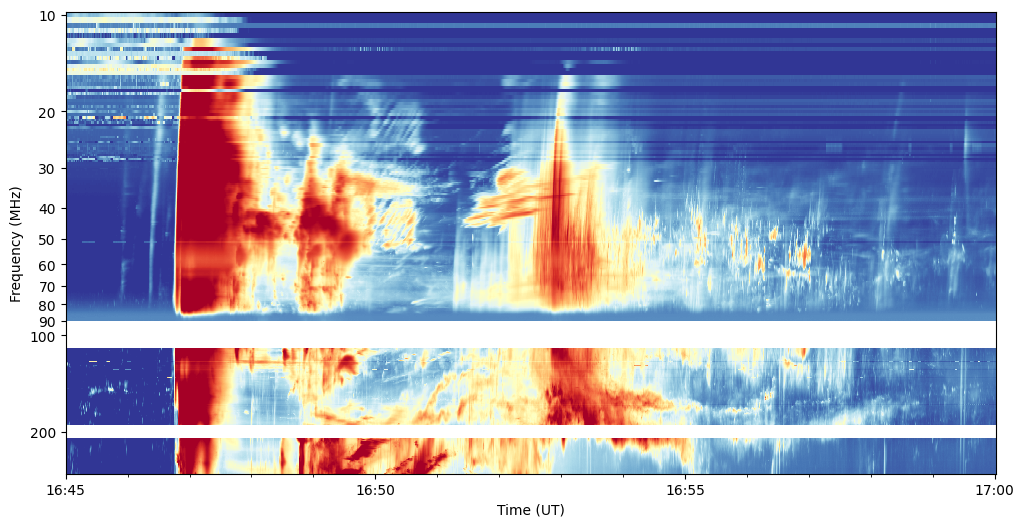

In [128]:
fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(111)
ax.pcolormesh(df_mode3_slice.index, df_mode3_slice.columns, df_mode3_slice.T,
                    vmin=np.percentile(df_mode3_slice, 10), vmax=np.percentile(df_mode3_slice, 97),
                    # vmin=min_range, vmax=max_range,
                    cmap='RdYlBu_r')
ax.pcolormesh(df_mode5_slice.index, df_mode5_slice.columns, df_mode5_slice.T,
                    vmin=np.percentile(df_mode5_slice, 10), vmax=np.percentile(df_mode5_slice, 97),
              # vmin=min_range, vmax=max_range,
                    cmap='RdYlBu_r')
ax.pcolormesh(df_mode7_slice.index, df_mode7_slice.columns, df_mode7_slice.T,
                    vmin=np.percentile(df_mode7_slice, 10), vmax=np.percentile(df_mode7_slice, 97),
              # vmin=min_range, vmax=max_range,
                    cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(ax.get_ylim()[::-1])
# fig.savefig(f'{path}/plots/realta_ilofar_{fig_title}_backgroundSubtracted.png', format='png', bbox_inches='tight')
plt.show()

In [299]:
# Slice the DataFrame between start_date and end_date
start_date = None #'2024-05-14 17:30:00'
# end_date   = '2024-05-14 17:13:00'

df_mode3_slice = df_mode3.loc[start_date:]
df_mode5_slice = df_mode5.loc[start_date:]
df_mode7_slice = df_mode7.loc[start_date:]

In [300]:
df_mode3_slice.shape

(45001, 199)

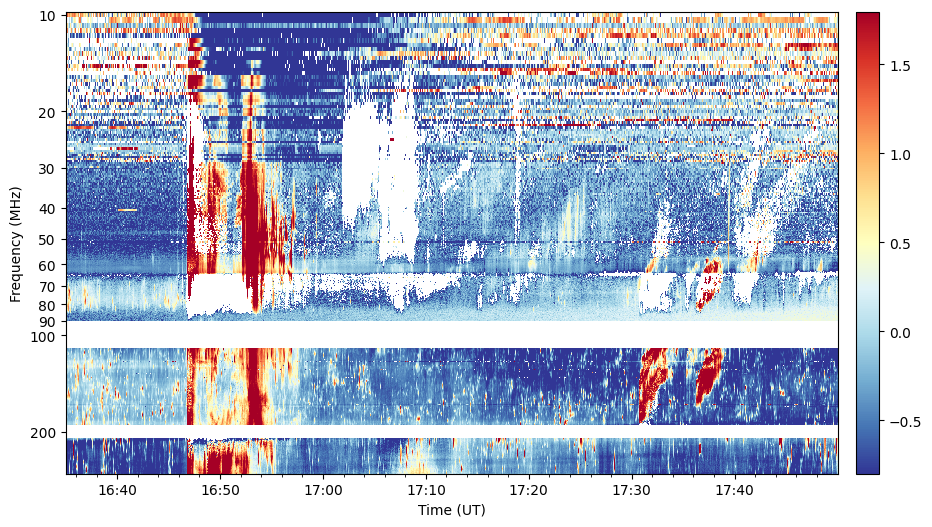

In [301]:
feature_type = 'all_dyspec' # typeII, typeIII, all_dyspec

fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(111)
img = ax.pcolormesh(df_mode3_slice.index, df_mode3_slice.columns, df_mode3_slice.T,
                    vmin=np.nanpercentile(df_mode3_slice, 10), vmax=np.nanpercentile(df_mode3_slice, 97),
                    # vmin=min_range, vmax=max_range,
                    cmap='RdYlBu_r')
ax.pcolormesh(df_mode5_slice.index, df_mode5_slice.columns, df_mode5_slice.T,
                    vmin=np.nanpercentile(df_mode5_slice, 10), vmax=np.nanpercentile(df_mode5_slice, 97),
              # vmin=min_range, vmax=max_range,
                    cmap='RdYlBu_r')
ax.pcolormesh(df_mode7_slice.index, df_mode7_slice.columns, df_mode7_slice.T,
                    vmin=np.nanpercentile(df_mode7_slice, 10), vmax=np.nanpercentile(df_mode7_slice, 97),
              # vmin=min_range, vmax=max_range,
                    cmap='RdYlBu_r')
ax.set_yscale('log')
fig.colorbar(img, pad=0.02)

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(ax.get_ylim()[::-1])
fig.savefig(f'{path}/plots/ilofar_{str(df_mode3_slice.index[0].date())}_{feature_type}_stokes{stokes}_backgroundSubtracted.png', format='png', bbox_inches='tight')
plt.show()

---

### Calculate the degree of circular polarization

In [289]:
# Load the dataframes from the pickle files
Tres = 10

df_mode3_stokesI = pd.read_pickle(f'{path}/df_mode3_{Tres}ms_stokesI.pkl')
df_mode5_stokesI = pd.read_pickle(f'{path}/df_mode5_{Tres}ms_stokesI.pkl')
df_mode7_stokesI = pd.read_pickle(f'{path}/df_mode7_{Tres}ms_stokesI.pkl')
time_stokesI = np.load(f'{path}/time_{Tres}ms_stokesI.npy', allow_pickle=True)

freqs_mode3_stokesI = df_mode3_stokesI.columns
freqs_mode5_stokesI = df_mode5_stokesI.columns
freqs_mode7_stokesI = df_mode7_stokesI.columns

# remove the const background
mode3_new_stokesI = df_mode3_stokesI.values - np.tile(np.nanmean(df_mode3_stokesI.values,0), (df_mode3_stokesI.values.shape[0],1))
mode5_new_stokesI = df_mode5_stokesI.values - np.tile(np.nanmean(df_mode5_stokesI.values,0), (df_mode5_stokesI.values.shape[0],1))
mode7_new_stokesI = df_mode7_stokesI.values - np.tile(np.nanmean(df_mode7_stokesI.values,0), (df_mode7_stokesI.values.shape[0],1))

del df_mode3_stokesI
del df_mode5_stokesI
del df_mode7_stokesI

df_mode3_stokesI = pd.DataFrame(data=mode3_new_stokesI, columns=freqs_mode3_stokesI)
df_mode5_stokesI = pd.DataFrame(data=mode5_new_stokesI, columns=freqs_mode5_stokesI)
df_mode7_stokesI = pd.DataFrame(data=mode7_new_stokesI, columns=freqs_mode7_stokesI)

# Ensure the 'time' column is in datetime format
df_mode3_stokesI.index = pd.to_datetime(time_stokesI)
df_mode5_stokesI.index = pd.to_datetime(time_stokesI)
df_mode7_stokesI.index = pd.to_datetime(time_stokesI)

# # downsample the data
# df_mode3_stokesI = df_mode3_stokesI.resample('100ms').mean()
# df_mode5_stokesI = df_mode5_stokesI.resample('100ms').mean()
# df_mode7_stokesI = df_mode7_stokesI.resample('100ms').mean()

In [290]:
df_mode3_stokesV = pd.read_pickle(f'{path}/df_mode3_{Tres}ms_stokesV.pkl')
df_mode5_stokesV = pd.read_pickle(f'{path}/df_mode5_{Tres}ms_stokesV.pkl')
df_mode7_stokesV = pd.read_pickle(f'{path}/df_mode7_{Tres}ms_stokesV.pkl')
time_stokesV = np.load(f'{path}/time_{Tres}ms_stokesV.npy', allow_pickle=True)

freqs_mode3_stokesV = df_mode3_stokesV.columns
freqs_mode5_stokesV = df_mode5_stokesV.columns
freqs_mode7_stokesV = df_mode7_stokesV.columns

# remove the const background
mode3_new_stokesV = df_mode3_stokesV.values - np.tile(np.nanmean(df_mode3_stokesV.values,0), (df_mode3_stokesV.values.shape[0],1))
mode5_new_stokesV = df_mode5_stokesV.values - np.tile(np.nanmean(df_mode5_stokesV.values,0), (df_mode5_stokesV.values.shape[0],1))
mode7_new_stokesV = df_mode7_stokesV.values - np.tile(np.nanmean(df_mode7_stokesV.values,0), (df_mode7_stokesV.values.shape[0],1))

del df_mode3_stokesV
del df_mode5_stokesV
del df_mode7_stokesV

df_mode3_stokesV = pd.DataFrame(data=mode3_new_stokesV, columns=freqs_mode3_stokesV)
df_mode5_stokesV = pd.DataFrame(data=mode5_new_stokesV, columns=freqs_mode5_stokesV)
df_mode7_stokesV = pd.DataFrame(data=mode7_new_stokesV, columns=freqs_mode7_stokesV)

# Ensure the 'time' column is in datetime format
df_mode3_stokesV.index = pd.to_datetime(time_stokesV)
df_mode5_stokesV.index = pd.to_datetime(time_stokesV)
df_mode7_stokesV.index = pd.to_datetime(time_stokesV)

# # downsample the data
# df_mode3_stokesV = df_mode3_stokesV.resample('100ms').mean()
# df_mode5_stokesV = df_mode5_stokesV.resample('100ms').mean()
# df_mode7_stokesV = df_mode7_stokesV.resample('100ms').mean()

In [291]:
df_mode3_stokesVI = df_mode3_stokesV / df_mode3_stokesI
df_mode5_stokesVI = df_mode5_stokesV / df_mode5_stokesI
df_mode7_stokesVI = df_mode7_stokesV / df_mode7_stokesI

# downsample the data
# df_mode3_stokesVI = df_mode3_stokesVI.resample('100ms').apply(np.nanmean)
# df_mode5_stokesVI = df_mode5_stokesVI.resample('100ms').apply(np.nanmean)
# df_mode7_stokesVI = df_mode7_stokesVI.resample('100ms').apply(np.nanmean)

df_mode3_stokesVI = df_mode3_stokesVI.resample('100ms').mean()
df_mode5_stokesVI = df_mode5_stokesVI.resample('100ms').mean()
df_mode7_stokesVI = df_mode7_stokesVI.resample('100ms').mean()

In [292]:
# Slice the DataFrame between start_date and end_date
start_date = None #'2024-05-14 17:30:00'

df_mode3_stokesVI_slice = df_mode3_stokesVI.loc[start_date:]
df_mode5_stokesVI_slice = df_mode5_stokesVI.loc[start_date:]
df_mode7_stokesVI_slice = df_mode7_stokesVI.loc[start_date:]

In [293]:
print('Max of Max:', max(np.nanmax(df_mode3_stokesVI_slice), np.nanmax(df_mode5_stokesVI_slice), np.nanmax(df_mode7_stokesVI_slice)))
print('Min of Min', min(np.nanmin(df_mode3_stokesVI_slice), np.nanmin(df_mode5_stokesVI_slice), np.nanmin(df_mode7_stokesVI_slice)))

Max of Max: 16520625.001787147
Min of Min -29062255.737883285


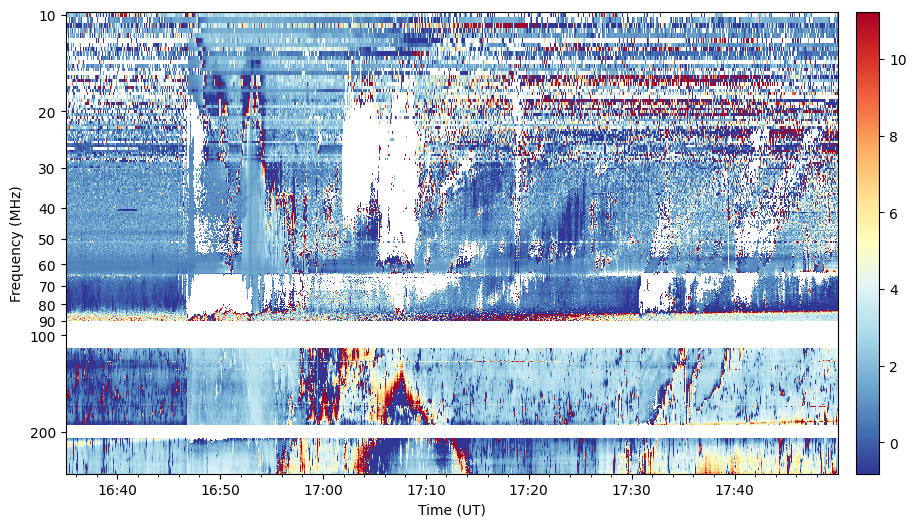

In [294]:
min_range = -1178161
max_range = 16520625

fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(111)
img = ax.pcolormesh(df_mode3_stokesVI_slice.index, df_mode3_stokesVI_slice.columns, df_mode3_stokesVI_slice.T,
                    vmin=np.nanpercentile(df_mode3_stokesVI_slice, 10), vmax=np.nanpercentile(df_mode3_stokesVI_slice, 97),
                    # vmin=min_range, vmax=max_range,
                    cmap='RdYlBu_r')
ax.pcolormesh(df_mode5_stokesVI_slice.index, df_mode5_stokesVI_slice.columns, df_mode5_stokesVI_slice.T,
                    vmin=np.nanpercentile(df_mode5_stokesVI_slice, 10), vmax=np.nanpercentile(df_mode5_stokesVI_slice, 97),
              # vmin=min_range, vmax=max_range,
                    cmap='RdYlBu_r')
ax.pcolormesh(df_mode7_stokesVI_slice.index, df_mode7_stokesVI_slice.columns, df_mode7_stokesVI_slice.T,
                    vmin=np.nanpercentile(df_mode7_stokesVI_slice, 10), vmax=np.nanpercentile(df_mode7_stokesVI_slice, 97),
              # vmin=min_range, vmax=max_range,
                    cmap='RdYlBu_r')
ax.set_yscale('log')
fig.colorbar(img, pad=0.02)

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(ax.get_ylim()[::-1])
fig.savefig(f'{path}/plots/ilofar_{str(df_mode3_stokesVI_slice.index[0].date())}_{feature_type}_stokesVI_backgroundSubtracted.png', format='png', bbox_inches='tight')
plt.show()

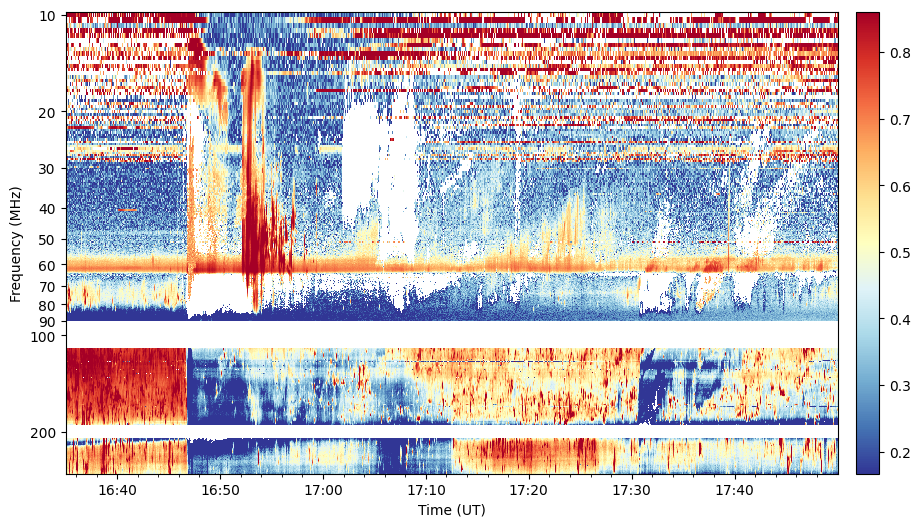

In [295]:
# Load the dataframes from the pickle files
Tres = 10

df_mode3_stokesI = pd.read_pickle(f'{path}/df_mode3_{Tres}ms_stokesI.pkl')
df_mode5_stokesI = pd.read_pickle(f'{path}/df_mode5_{Tres}ms_stokesI.pkl')
df_mode7_stokesI = pd.read_pickle(f'{path}/df_mode7_{Tres}ms_stokesI.pkl')
time_stokesI = np.load(f'{path}/time_{Tres}ms_stokesI.npy', allow_pickle=True)

# Ensure the 'time' column is in datetime format
df_mode3_stokesI.index = pd.to_datetime(time_stokesI)
df_mode5_stokesI.index = pd.to_datetime(time_stokesI)
df_mode7_stokesI.index = pd.to_datetime(time_stokesI)

df_mode3_stokesV = pd.read_pickle(f'{path}/df_mode3_{Tres}ms_stokesV.pkl')
df_mode5_stokesV = pd.read_pickle(f'{path}/df_mode5_{Tres}ms_stokesV.pkl')
df_mode7_stokesV = pd.read_pickle(f'{path}/df_mode7_{Tres}ms_stokesV.pkl')
time_stokesV = np.load(f'{path}/time_{Tres}ms_stokesV.npy', allow_pickle=True)

# Ensure the 'time' column is in datetime format
df_mode3_stokesV.index = pd.to_datetime(time_stokesV)
df_mode5_stokesV.index = pd.to_datetime(time_stokesV)
df_mode7_stokesV.index = pd.to_datetime(time_stokesV)

df_mode3_stokesVI = df_mode3_stokesV / df_mode3_stokesI
df_mode5_stokesVI = df_mode5_stokesV / df_mode5_stokesI
df_mode7_stokesVI = df_mode7_stokesV / df_mode7_stokesI

# downsample the data
df_mode3_stokesVI = df_mode3_stokesVI.resample('100ms').mean()
df_mode5_stokesVI = df_mode5_stokesVI.resample('100ms').mean()
df_mode7_stokesVI = df_mode7_stokesVI.resample('100ms').mean()


# Slice the DataFrame between start_date and end_date
start_date = None #'2024-05-14 17:30:00'

df_mode3_stokesVI_slice = df_mode3_stokesVI.loc[start_date:]
df_mode5_stokesVI_slice = df_mode5_stokesVI.loc[start_date:]
df_mode7_stokesVI_slice = df_mode7_stokesVI.loc[start_date:]



fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(111)
img = ax.pcolormesh(df_mode3_stokesVI_slice.index, df_mode3_stokesVI_slice.columns, df_mode3_stokesVI_slice.T,
                    vmin=np.nanpercentile(df_mode3_stokesVI_slice, 10), vmax=np.nanpercentile(df_mode3_stokesVI_slice, 97),
                    cmap='RdYlBu_r')
ax.pcolormesh(df_mode5_stokesVI_slice.index, df_mode5_stokesVI_slice.columns, df_mode5_stokesVI_slice.T,
                    vmin=np.nanpercentile(df_mode5_stokesVI_slice, 10), vmax=np.nanpercentile(df_mode5_stokesVI_slice, 97),
                    cmap='RdYlBu_r')
ax.pcolormesh(df_mode7_stokesVI_slice.index, df_mode7_stokesVI_slice.columns, df_mode7_stokesVI_slice.T,
                    vmin=np.nanpercentile(df_mode7_stokesVI_slice, 10), vmax=np.nanpercentile(df_mode7_stokesVI_slice, 97),
                    cmap='RdYlBu_r')
ax.set_yscale('log')
fig.colorbar(img, pad=0.02)

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(ax.get_ylim()[::-1])
fig.savefig(f'{path}/plots/ilofar_{str(df_mode3_stokesVI_slice.index[0].date())}_{feature_type}_stokesVI.png', format='png', bbox_inches='tight')
plt.show()

In [203]:
df_mode3_stokesVI_slice.shape, df_mode5_stokesVI_slice.shape, df_mode7_stokesVI_slice.shape

((12000, 199), (12000, 200), (12000, 88))

In [206]:
np.zeros((df_mode3_stokesVI_slice.shape[0], df_mode3_stokesVI_slice.shape[1] + df_mode5_stokesVI_slice.shape[1] + df_mode7_stokesVI_slice.shape[1])).shape

(12000, 487)

In [211]:
combined_df = pd.concat([df_mode3_stokesVI_slice, df_mode3_stokesVI_slice, df_mode7_stokesVI_slice], axis=1)
combined_df.shape

(12000, 486)

In [212]:
combined_df.head()

90.000000   89.595960   89.191919   88.787879   \
2024-05-14 17:30:00.000    3.627921    5.562758    3.426342    6.567691   
2024-05-14 17:30:00.100    3.839219    6.058525    3.825153    5.774212   
2024-05-14 17:30:00.200    3.864924    7.069719    4.875787    1.878291   
2024-05-14 17:30:00.300    2.613628    5.211240    4.841502    5.403580   
2024-05-14 17:30:00.400    4.181111    4.886845    6.761228    2.553884   

                         88.383838   87.979798   87.575758   87.171717   \
2024-05-14 17:30:00.000    4.235146    4.962476    2.695139    3.829957   
2024-05-14 17:30:00.100    1.399395    5.356458    5.709317    5.486444   
2024-05-14 17:30:00.200    4.297647    6.021575    5.556708    4.163011   
2024-05-14 17:30:00.300    4.293160    6.457698    4.586210    3.845599   
2024-05-14 17:30:00.400    2.158600    5.279329    4.226290    3.438358   

                         86.767677   86.363636   ...  216.206897   215.517241  \
2024-05-14 17:30:00.000    8.309664    3.714009  ... -288.496976   133.638888   
2024-05-14 17:30:00.100    3.846807    2.854478  ...  -81.693712  4753.861359   
2024-05-14 17:30:00.200    3.297591    6.183934  ...  -87.277709    10.933436   
2024-05-14 17:30:00.300    1.647533    9.149091  ...   13.542836    36.372082   
2024-05-14 17:30:00.400    7.559163   -9.475856  ...    8.905806     8.811828   

                         214.827586  214.137931  213.448276  212.758621  \
2024-05-14 17:30:00.000  268.098311  -34.120604  -78.970293  -24.944317   
2024-05-14 17:30:00.100   75.444067  277.249531 -123.609233   31.417129   
2024-05-14 17:30:00.200   59.005619   37.623240   27.050664   21.600468   
2024-05-14 17:30:00.300   15.529762   14.263588   13.241922   10.695479   
2024-05-14 17:30:00.400    9.168647    9.376109    9.605864   10.032520   

                         212.068966  211.379310  210.689655  210.000000  
2024-05-14 17:30:00.000  -26.631714  -18.710529  -16.977303  -10.960870  
2024-05-14 17:30:00.100  -45.941632  -22.539710   30.743903    8.390387  
2024-05-14 17:30:00.200   18.384668   16.808017   18.192001   18.336009  
2024-05-14 17:30:00.300   10.829243   11.208418   11.341187   11.586206  
2024-05-14 17:30:00.400    9.889459   10.717467   11.601663   11.496981  

[5 rows x 486 columns]

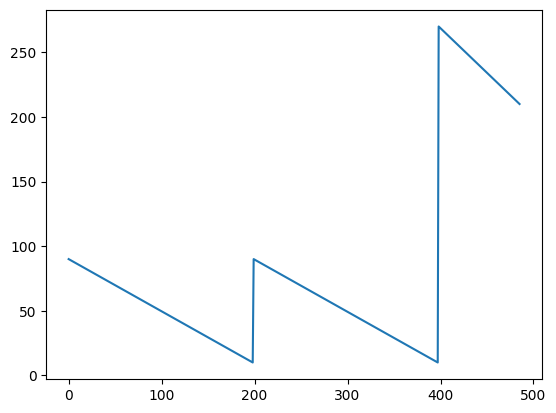

In [221]:
plt.plot(combined_df.columns)

In [228]:
combined_df = []
combined_df.append(df_mode7_stokesVI_slice)
combined_df.append(df_mode3_stokesVI_slice)
combined_df.append(df_mode3_stokesVI_slice)

In [230]:
merged_df = pd.concat(combined_df, axis=1)

# Add NaN for missing values
merged_df = merged_df.apply(lambda x: x if isinstance(x, pd.Series) else np.nan)

merged_df.shape

(12000, 486)

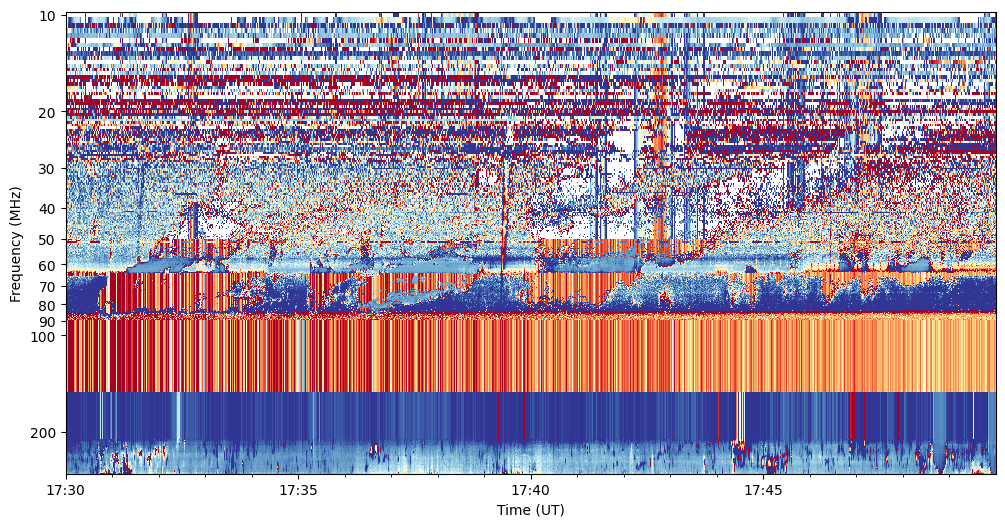

In [231]:
min_range = 0
max_range = 5

fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(111)
ax.pcolormesh(merged_df.index, merged_df.columns, merged_df.T,
                    vmin=min_range, vmax=max_range,
                    cmap='RdYlBu_r')
ax.set_yscale('log')

# Define the custom ticks
custom_ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
ax.set_yticks(custom_ticks)
ax.set_yticklabels([str(tick) for tick in custom_ticks])
ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()